In [1]:
!pip install wget
!pip install onnx
!pip install onnxruntime
!pip install onnxscript

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=0d4ff8a75c64d26e7aad218b4ae748958fabb18006722e70ace4b5ba1f453355
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.8/553.8 kB 6.2 MB/s eta 0:00:00


## Download pre-trained mobilenet with sample test data from ONNX model zoo

In [2]:
!wget https://github.com/onnx/models/raw/main/validated/vision/classification/mobilenet/model/mobilenetv2-12.tar.gz?download= -O mobilenetv2-12.tar.gz
!tar -xzvf "mobilenetv2-12.tar.gz"
!rm "mobilenetv2-12.tar.gz"
!wget https://github.com/srirammanikumar/DogBreedClassifier/blob/master/images/Labrador_retriever_06457.jpg?raw=true -O labrador.jpg

--2024-03-07 03:42:44--  https://github.com/onnx/models/raw/main/validated/vision/classification/mobilenet/model/mobilenetv2-12.tar.gz?download=
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/onnx/models/main/validated/vision/classification/mobilenet/model/mobilenetv2-12.tar.gz?download=true [following]
--2024-03-07 03:42:45--  https://media.githubusercontent.com/media/onnx/models/main/validated/vision/classification/mobilenet/model/mobilenetv2-12.tar.gz?download=true
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13498787 (13M) [application/octet-stream]
Saving to: ‘mobilenetv

## Imports


In [3]:
import onnx
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt
from PIL import Image

## MobileNet Preprocess Code

In [4]:
def preprocess(image):
    # resize so that the shorter side is 256, maintaining aspect ratio
    def image_resize(image, min_len):
        image = Image.fromarray(image)
        ratio = float(min_len) / min(image.size[0], image.size[1])
        if image.size[0] > image.size[1]:
            new_size = (int(round(ratio * image.size[0])), min_len)
        else:
            new_size = (min_len, int(round(ratio * image.size[1])))
        image = image.resize(new_size, Image.BILINEAR)
        return np.array(image)
    image = image_resize(image, 256)

    # Crop centered window 224x224
    def crop_center(image, crop_w, crop_h):
        h, w, c = image.shape
        start_x = w//2 - crop_w//2
        start_y = h//2 - crop_h//2
        return image[start_y:start_y+crop_h, start_x:start_x+crop_w, :]
    image = crop_center(image, 224, 224)

    # transpose
    image = image.transpose(2, 0, 1)

    # convert the input data into the float32 input
    img_data = image.astype('float32')

    # normalize
    mean_vec = np.array([0.485, 0.456, 0.406])
    stddev_vec = np.array([0.229, 0.224, 0.225])
    norm_img_data = np.zeros(img_data.shape).astype('float32')
    for i in range(img_data.shape[0]):
        norm_img_data[i,:,:] = (img_data[i,:,:]/255 - mean_vec[i]) / stddev_vec[i]

    # add batch channel
    norm_img_data = norm_img_data.reshape(1, 3, 224, 224).astype('float32')
    return norm_img_data

## Make a Preprocess Torch Model for ONXX

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import v2

In [6]:
class Normalize(nn.Module):
    def __init__(self):
        super().__init__()
        # self.transforms = T.Compose([
        #     T.Resize(size=(224, 224), antialias=True), # Can either use Resize or RandomResizedCrop
        #     T.ConvertImageDtype(torch.float32),
        #     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # ])
        self.transforms = T.Compose([
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def forward(self, x):
        # x = x.permute(0, 3, 1, 2)
        x = self.transforms(x)
        x = x.reshape(1, 3, 224, 224)
        return x

In [7]:
o = torch.randint(0, 256, (1, 3, 224, 224), dtype=torch.uint8)
o.shape

torch.Size([1, 3, 224, 224])

In [8]:
normalize_model = Normalize()

In [9]:
o_p = normalize_model(o)
o_p.shape

torch.Size([1, 3, 224, 224])

In [10]:
o.dtype, o_p.dtype

(torch.uint8, torch.float32)

In [11]:
torch.min(o_p)

tensor(-2.1179)

In [12]:
# x = torch.randint(0, 256, (1,224,224,3), dtype=torch.uint8)
# export_options = torch.onnx.ExportOptions(dynamic_shapes=True)
# onnx_program = torch.onnx.dynamo_export(
#     preprocess_model,
#     x,
#     export_options=export_options)
# onnx_program.save("preprocess.onnx")

In [13]:
x = torch.randint(0, 256, (1,3,224,224), dtype=torch.uint8)
torch.onnx.export(
    normalize_model,
    x,
    "normalize.onnx",
    input_names = ['input'],   # the model's input names
    output_names = ['norm_output'], # the model's output names
    dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                  'norm_output' : {0 : 'batch_size'}})

In [14]:
onnx_model = onnx.load("normalize.onnx")
onnx.checker.check_model(onnx_model)
print(onnx.helper.printable_graph(onnx_model.graph))

graph main_graph (
  %input[UINT8, batch_sizex3x224x224]
) {
  %/Cast_output_0 = Cast[to = 1](%input)
  %/Constant_output_0 = Constant[value = <Scalar Tensor []>]()
  %/Div_output_0 = Div(%/Cast_output_0, %/Constant_output_0)
  %/Constant_1_output_0 = Constant[value = <Tensor>]()
  %/Sub_output_0 = Sub(%/Div_output_0, %/Constant_1_output_0)
  %/Constant_2_output_0 = Constant[value = <Tensor>]()
  %/Div_1_output_0 = Div(%/Sub_output_0, %/Constant_2_output_0)
  %/Constant_3_output_0 = Constant[value = <Tensor>]()
  %norm_output = Reshape[allowzero = 0](%/Div_1_output_0, %/Constant_3_output_0)
  return %norm_output
}


### Run the normalize to check if it works correctly

In [15]:
ort_session = ort.InferenceSession("normalize.onnx")

outputs = ort_session.run(
    ["norm_output"],
    {"input": np.random.randint(0, 256, (1,3,224,224), dtype=np.uint8)},
)
outputs[0].min(), outputs[0].max()

(-2.117904, 2.64)

## Make Transpose + Resize ONNX Models

## Define graph input and output

In [16]:
model_input_name = "X"
X = onnx.helper.make_tensor_value_info(
    model_input_name,
    onnx.TensorProto.UINT8,
    [None, None, None, 3]) # notice that we are leaving just channels dimension fixed, Batch size, width and heigh is not known in advance


model_output_name = "Y"
Y = onnx.helper.make_tensor_value_info(
    model_output_name,
    onnx.TensorProto.UINT8,
    [None, 3, 224, 224]) # output is resized but also transposed to be ready as an input to MobileNet model

## Define resize and transpose operation

### [Resize](https://github.com/onnx/onnx/blob/main/docs/Operators.md#Resize) operation input constants

In [17]:
resize_node_output_name = "Resize_Y"
Y_resize = onnx.helper.make_tensor_value_info(resize_node_output_name,
                                       onnx.TensorProto.UINT8,
                                       [None, 224, 224, 3])



roi = onnx.helper.make_node("Constant", inputs=[], outputs=["roi"], name="roi-constant",
                           value=onnx.helper.make_tensor(name="roi-values",
                                                         data_type=onnx.TensorProto.FLOAT,
                                                         dims=np.array([]).shape,
                                                         vals=np.array([]).flatten()
                                                         ))
scales = onnx.helper.make_node("Constant", inputs=[], outputs=["scales"], name="scales-constant",
                           value=onnx.helper.make_tensor(name="scales-values",
                                                         data_type=onnx.TensorProto.FLOAT,
                                                         dims=np.array([]).shape,
                                                         vals=np.array([]).flatten()
                                                         ))

output_size = onnx.helper.make_node("Constant", inputs=[], outputs=["output_size"], name="output_size-constant",
                           value=onnx.helper.make_tensor(name="output_size-values",
                                                         data_type=onnx.TensorProto.INT64,
                                                         dims=np.array([1, 224, 224, 3]).shape,
                                                         vals=np.array([1, 224, 224, 3]).flatten()
                                                         ))

###[Transpose](https://github.com/onnx/onnx/blob/main/docs/Operators.md#transpose) operation input constants

In [18]:
# Permute dimension, after resize they are in this order
# N W H C
# 0 1 2 3
# After transpose we want them in shape
# N C W H
# 0 3 1 2
perm = onnx.helper.make_node("Constant", inputs=[], outputs=["perm"], name="perm-constant",
                           value=onnx.helper.make_tensor(name="perm-values",
                                                         data_type=onnx.TensorProto.INT64,
                                                         dims=np.array([0,3,1,2]).shape,
                                                         vals=np.array([0,3,1,2]).flatten()
                                                         ))

### Create Resize and Transpose nodes

In [19]:
resize_node = onnx.helper.make_node("Resize", inputs=[model_input_name, "roi", "scales", "output_size"], outputs=[resize_node_output_name])
transpose_node = onnx.helper.make_node("Transpose", inputs=[resize_node_output_name], outputs=[model_output_name], perm=[0,3,1,2])

## Create graph and save to ONNX file

In [20]:
graph = onnx.helper.make_graph([roi, scales, output_size, resize_node, transpose_node], "resize", [X], [Y])

print(graph)

# Create the model (ModelProto instance)
model_def = onnx.helper.make_model(graph)

model_def = onnx.shape_inference.infer_shapes(model_def)

onnx.checker.check_model(model_def)
onnx.save(model_def, "resize.onnx")

node {
  output: "roi"
  name: "roi-constant"
  op_type: "Constant"
  attribute {
    name: "value"
    t {
      dims: 0
      data_type: 1
      name: "roi-values"
    }
    type: TENSOR
  }
}
node {
  output: "scales"
  name: "scales-constant"
  op_type: "Constant"
  attribute {
    name: "value"
    t {
      dims: 0
      data_type: 1
      name: "scales-values"
    }
    type: TENSOR
  }
}
node {
  output: "output_size"
  name: "output_size-constant"
  op_type: "Constant"
  attribute {
    name: "value"
    t {
      dims: 4
      data_type: 7
      int64_data: 1
      int64_data: 224
      int64_data: 224
      int64_data: 3
      name: "output_size-values"
    }
    type: TENSOR
  }
}
node {
  input: "X"
  input: "roi"
  input: "scales"
  input: "output_size"
  output: "Resize_Y"
  op_type: "Resize"
}
node {
  input: "Resize_Y"
  output: "Y"
  op_type: "Transpose"
  attribute {
    name: "perm"
    ints: 0
    ints: 3
    ints: 1
    ints: 2
    type: INTS
  }
}
name: "resize"


# Run the resize to check if it works correctly

In [21]:
sess = ort.InferenceSession("resize.onnx") # Start the inference session and open the model
X_input = np.random.randint(0, 256, (1,500,400,3), dtype=np.uint8)
print(f"Input shape: {X_input.shape}")

resize_output = sess.run(["Y"], {"X": X_input})[0]
print(f"Output shape: {np.shape(resize_output)}")
print(f"Output type: {resize_output.dtype}, Min: {resize_output.min()}, Max: {resize_output.max()}")

Input shape: (1, 500, 400, 3)
Output shape: (1, 3, 224, 224)
Output type: uint8, Min: 0, Max: 255


In [22]:
sess = ort.InferenceSession("normalize.onnx") # Start the inference session and open the model

normalize_output = ort_session.run(["norm_output"], {"input": np.random.randint(0, 256, (1,3,224,224), dtype=np.uint8)})[0]

print(f"Output shape: {np.shape(normalize_output)}")
print(f"Output type: {normalize_output.dtype}, Min: {normalize_output.min()}, Max: {normalize_output.max()}")

Output shape: (1, 3, 224, 224)
Output type: float32, Min: -2.1179039478302, Max: 2.640000104904175


In [23]:
sess = ort.InferenceSession("mobilenetv2-12/mobilenetv2-12.onnx") # Start the inference session and open the model
output = sess.run(None, {"input": normalize_output}) # Compute the standardized output
print("Check:")
print(np.shape(output))

Check:
(1, 1, 1000)


## Merge models to one

In [24]:
import onnx
from onnx.version_converter import convert_version

In [25]:
model1 = onnx.load('resize.onnx')
model1.ir_version = 9
model1 = convert_version(model1, 20)
model2 = onnx.load('normalize.onnx')
model2.ir_version = 9
model2 = convert_version(model2, 20)
model3 = onnx.load('mobilenetv2-12/mobilenetv2-12.onnx')
model3.ir_version = 9
model3 = convert_version(model3, 20)

combined_model = onnx.compose.merge_models(
    model1, model2,
    io_map=[('Y', 'input')])

combined_model = onnx.compose.merge_models(
    combined_model, model3,
    io_map=[('norm_output', 'input')])

In [44]:
onnx.save(combined_model, "mobilenetv2-12-preprocess.onnx")

## Check inference

In [27]:
!wget https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n02085936_Maltese_dog.JPEG -O maltese_dog.jpg

--2024-03-07 03:43:08--  https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n02085936_Maltese_dog.JPEG
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02085936_Maltese_dog.JPEG [following]
--2024-03-07 03:43:08--  https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02085936_Maltese_dog.JPEG
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23644 (23K) [image/jpeg]
Saving to: ‘maltese_dog.jpg’

maltese_dog.jpg     100%[===================>]  23.09K  --.-KB/s    in 0.001s  

2024-03-07 03:43:08 (34.5 MB/s) - ‘maltese_d

Image shape: (500, 375, 3)


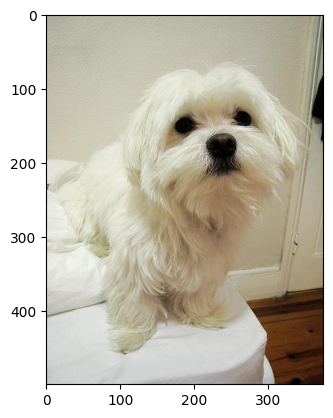

In [28]:
large_img = np.array(Image.open("maltese_dog.jpg"))

print(f"Image shape: {large_img.shape}")

plt.imshow(large_img)

In [29]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
import json
class_idx = json.load(open("imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

--2024-03-07 03:43:09--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.115.53, 54.231.171.192, 54.231.226.184, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.115.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.02s   

2024-03-07 03:43:09 (1.73 MB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



In [45]:
sess = ort.InferenceSession("mobilenetv2-12-preprocess.onnx") # Start the inference session and open the model
input_image = np.expand_dims(large_img.astype(np.uint8), 0)
output = sess.run(["output"], {"X": input_image}) # Compute the output
print("Check:")
print(np.shape(output))

index = np.argmax(output)
print("Index ", index)
print("Label ", idx2label[index])
print("Confidence ", np.max(output))

Check:
(1, 1, 1000)
Index  153
Label  Maltese_dog
Confidence  15.094408


# [Reference ONNX Code](https://colab.research.google.com/drive/1XHU4H2OnGW8b3LSMUlOitjdiOI-MukhY?authuser=2)

## Imports


In [31]:
# import onnx
# import numpy as np
# import onnxruntime as rt
# import matplotlib.pyplot as plt
# from PIL import Image

## Resizer dynamic

## Define graph input and output

In [32]:
# model_input_name = "X"
# X = onnx.helper.make_tensor_value_info(
#     model_input_name,
#     onnx.TensorProto.FLOAT,
#     [None, None, None, 3]) # notice that we are leaving just channels dimension fixed, Batch size, width and heigh is not known in advance


# model_output_name = "Y"
# Y = onnx.helper.make_tensor_value_info(
#     model_output_name,
#     onnx.TensorProto.FLOAT,
#     [None, 3, 224, 224]) # output is resized but also transposed to be ready as an input to MobileNet model

## Define resize and transpose operation

### [Resize](https://github.com/onnx/onnx/blob/main/docs/Operators.md#Resize) operation input constants

In [33]:
# resizer_node_output_name = "Resize_Y"
# Y_resize = onnx.helper.make_tensor_value_info(resizer_node_output_name,
#                                        onnx.TensorProto.FLOAT,
#                                        [None, 224, 224, 3])



# roi = onnx.helper.make_node("Constant", inputs=[], outputs=["roi"], name="roi-constant",
#                            value=onnx.helper.make_tensor(name="roi-values",
#                                                          data_type=onnx.TensorProto.FLOAT,
#                                                          dims=np.array([]).shape,
#                                                          vals=np.array([]).flatten()
#                                                          ))
# scales = onnx.helper.make_node("Constant", inputs=[], outputs=["scales"], name="scales-constant",
#                            value=onnx.helper.make_tensor(name="scales-values",
#                                                          data_type=onnx.TensorProto.FLOAT,
#                                                          dims=np.array([]).shape,
#                                                          vals=np.array([]).flatten()
#                                                          ))

# output_size = onnx.helper.make_node("Constant", inputs=[], outputs=["output_size"], name="output_size-constant",
#                            value=onnx.helper.make_tensor(name="output_size-values",
#                                                          data_type=onnx.TensorProto.INT64,
#                                                          dims=np.array([1, 224, 224, 3]).shape,
#                                                          vals=np.array([1, 224, 224, 3]).flatten()
#                                                          ))

###[Transpose](https://github.com/onnx/onnx/blob/main/docs/Operators.md#transpose) operation input constants

In [34]:
# # Permute dimension, after resize they are in this order
# # N W H C
# # 0 1 2 3
# # After transpose we want them in shape
# # N C W H
# # 0 3 1 2
# perm = onnx.helper.make_node("Constant", inputs=[], outputs=["perm"], name="perm-constant",
#                            value=onnx.helper.make_tensor(name="perm-values",
#                                                          data_type=onnx.TensorProto.INT64,
#                                                          dims=np.array([0,3,1,2]).shape,
#                                                          vals=np.array([0,3,1,2]).flatten()
#                                                          ))

### Create Resize and Transpose nodes

In [35]:
# resizer_node = onnx.helper.make_node("Resize", inputs=[model_input_name, "roi", "scales", "output_size"], outputs=[resizer_node_output_name])
# transpose_node = onnx.helper.make_node("Transpose", inputs=[resizer_node_output_name], outputs=[model_output_name], perm=[0,3,1,2])

## Create graph and save to ONNX file

In [36]:
# g = onnx.helper.make_graph([roi, scales, output_size, resizer_node, transpose_node], "resizer", [X], [Y])

# print(g)

# # Create the model (ModelProto instance)
# model_def = onnx.helper.make_model(g)

# model_def = onnx.shape_inference.infer_shapes(model_def)

# onnx.checker.check_model(model_def)
# onnx.save(model_def, "resizer.onnx")

# Run the resize to check if it works correctly

In [37]:
# sess = rt.InferenceSession("resizer.onnx") # Start the inference session and open the model
# X_input = np.ones((1, 2311,1231, 3), dtype=np.float32) # Use the input_example from block 0 as input
# print(f"Input shape: {X_input.shape}")

# output = sess.run(["Y"], {"X": X_input}) # Compute the standardized output
# print(f"Output shape: {np.shape(output)}")

# Run the squeezenet with the output of resizer

In [38]:
# sess = rt.InferenceSession("/content/squeezenet1.0-12.onnx") # Start the inference session and open the model
# output = sess.run(["softmaxout_1"], {"data_0": output[0]}) # Compute the standardized output
# print("Check:")
# print(np.shape(output))

## Merge models to one

In [39]:
# model1 = onnx.load('resizer.onnx')
# model2 = onnx.load('/content/squeezenet1.0-12.onnx')


# combined_model = onnx.compose.merge_models(
#     model1, model2,
#     io_map=[('Y', 'data_0')],
#     outputs=['softmaxout_1']
# )

In [40]:
# onnx.save(combined_model, "combined_dynamic_input.onnx")

## Check inference

In [41]:
# !wget https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n02085936_Maltese_dog.JPEG

In [42]:
# large_img = np.array(Image.open("n02085936_Maltese_dog.JPEG"))

# print(f"Image shape: {large_img.shape}")

# plt.imshow(large_img)

In [43]:
# sess = rt.InferenceSession("combined_dynamic_input.onnx") # Start the inference session and open the model
# input_image = np.expand_dims(large_img.astype(np.float32), 0) # Use the input_example from block 0 as input
# output = sess.run(["softmaxout_1"], {"X": input_image}) # Compute the standardized output
# print("Check:")
# print(np.shape(output))

# print("Index ", np.argmax(output))
# print("Confidence ", np.max(output))